In [1]:
import sys, pickle
sys.path.append('../src')
import numpy as np
from scipy.linalg import svd
from scipy.stats import permutation_test
from tqdm import tqdm
from matplotlib import colormaps
import matplotlib.pyplot as plt
from utils import *
from visualization import *
rng = np.random.default_rng()

- onm = disrupt memory mode
- offm = disrupt landscape mode

In [2]:
xs_offm = np.linspace(-1, 1, num=7)
xs_onm = np.linspace(-0.25, 1.25, num=7)

In [3]:
rate_onm, rate_offm = [], []
# correlations between disrupted J and syllables for the four disruption cases
corr_ctrl, corr_disr = [], []
svds, pwsim_sv, corr_syl_sv = [], [], []

for i in tqdm(range(1,11)):
    with open('../results/EIrec_J_disrupt_exp%s.pkl' % i, 'rb') as f:
        res = pickle.load(f)
        NE = res['syl'].shape[1]
        
        rate_onm += res['on_manifold']['rate']
        rate_offm += res['off_manifold']['rate']

        corr_ctrl.append(correlation(res['Js'][-1][:NE,:NE], res['syl'], dim=2))
        corr_disr.extend(res['J_disr_corrs'])
        
        svds.append(list(map(svd, res['Js'])))
        f = lambda sv: correlation(sv[0][:NE,:].T, res['syl'], dim=2)
        corr_syl_sv.append(np.stack(list(map(f, svds[-1]))))
        pwsim_sv.append(np.stack(list(map(lambda sv: svds[-1][0][0].T @ sv[0], svds[-1]))))
            
print(res['order'])
N_case = len(res['order'])
N_shuffle = len(res['on_manifold']['rate']) // N_case

# (simulations * cases, perturbation values, E neurons)
rate_onm, rate_offm = np.stack(rate_onm), np.stack(rate_offm)
# (simulations * cases, E neurons, syllable)
corr_ctrl, corr_disr = np.stack(corr_ctrl), np.stack(corr_disr)
# (simulations, renditions, neurons, syllable or neurons)
corr_syl_sv, pwsim_sv = np.stack(corr_syl_sv), np.stack(pwsim_sv)

100%|███████████████████████████████████████████| 10/10 [00:43<00:00,  4.40s/it]


['original', 'landscape', '10 memory', '1 rand', '10 rand']


In [4]:
case_names = ['\noriginal\n', 'without\nlandscape\nmode', 'without 10\nmemory\nmodes', 
              'without 1\nrandom\nmode', 'without 10\nrandom\nmodes']

1
28


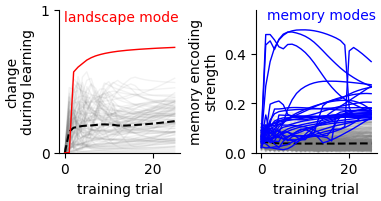

In [5]:
tid = 3
change = 1 - np.abs(pwsim_sv[tid,:,:,:100]).max(axis=1)
i_max = np.argmax(change[-1]) # max change at the last time step
print(i_max)
i_other = [i for i in range(change.shape[1]) if i != i_max]
fig, ax = plt.subplots(1, 2, figsize=(3.8,2))
ax[0].plot(change, c='grey', alpha=0.1, lw=1, zorder=-1)
ax[0].plot(change[:,i_other].mean(axis=1), c='k', ls='--', zorder=1)
ax[0].plot(change[:,i_max], c='r', lw=1, zorder=2)
ax[0].text(change.shape[0], 0.9, 'landscape mode', ha='right', va='bottom', 
           color='r', zorder=2)
ax[0].set(ylabel='change\nduring learning', yticks=[0, 1], ylim=[0, 1])
ax[0].set_xlabel('training trial', va='top')
ax[0].set_rasterization_zorder(0)

corr_syl_evo = np.abs(corr_syl_sv[tid]).max(axis=-1)
mask = corr_syl_evo[-1] > corr_syl_evo[0].max()
print(sum(mask))
ax[1].plot(corr_syl_evo[:,~mask], c='grey', alpha=0.1, lw=1, zorder=-1)
ax[1].plot(corr_syl_evo[:,~mask].mean(axis=1), c='k', ls='--', zorder=1)
ax[1].plot(corr_syl_evo[:,mask], c='b', alpha=1, lw=1, zorder=2)
ax[1].text(change.shape[0], 0.54, 'memory modes', ha='right', c='b', zorder=2)
ax[1].set(ylabel='memory encoding\nstrength', ylim=[0, 0.58])
ax[1].set_xlabel('training trial', va='top')
ax[1].set_rasterization_zorder(0)
fig.savefig('../svg/mode_learning_curves.svg')

0.0002


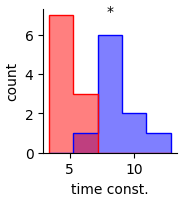

In [6]:
def get_time_const(y):
    t = np.arange(len(y)-5)
    y = 1 - (y - y.min()) / (y.max() - y.min())
    log_y = np.log(y[:-5]+1e-5)
    tau, a = np.linalg.lstsq(np.stack([t, np.ones(len(t))], axis=1), log_y)[0]
    return -1/tau

tc_landscape, tc_memory = [], []
for i in range(pwsim_sv.shape[0]):
    change = 1 - np.abs(pwsim_sv[i,:,:,:100]).max(axis=1)
    i_max = np.argmax(change[-1]) # max change at the last time step
    tc_landscape.append(get_time_const(change[:,i_max]))
    
    corr_syl_evo = np.abs(corr_syl_sv[i]).max(axis=-1)
    mask = corr_syl_evo[-1] > corr_syl_evo[0].max()
    memory_mode_mean = corr_syl_evo[:,mask].mean(axis=1)
    tc_memory.append(get_time_const(memory_mode_mean))

fig, ax = plt.subplots(1, figsize=(1.8,2))
kwargs = dict(x=[tc_landscape, tc_memory], bins=5, color=['r', 'b'])
ax.hist(**kwargs, histtype='stepfilled', alpha=0.5)
ax.hist(**kwargs, histtype='step', alpha=1)
def statistic(x, y):
    return x.mean() - y.mean()
p = permutation_test([tc_landscape, tc_memory], statistic, alternative='less').pvalue
print(p*2)
if p < 0.05:
    ax.text(sum(ax.get_xlim())/2, ax.get_ylim()[1]-0.5, '*', ha='center', va='bottom')
else:
    ax.text(sum(ax.get_xlim())/2, ax.get_ylim()[1]-0.5, 'ns', ha='center', va='bottom')
ax.set(xlabel='time const.', ylabel='count')
fig.savefig('../svg/supplementary/mode_time_const.svg')

In [7]:
svd_pre, svd_post = svd(res['Js'][0]), svd(res['Js'][-1])

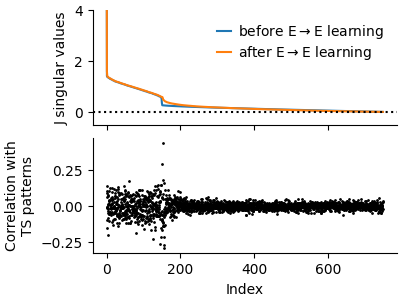

In [8]:
fig, ax = plt.subplots(2, figsize=(4,3), sharex='all')
ax[0].plot(svd_pre[1], label='before E$\\to$E learning')
ax[0].plot(svd_post[1], label='after E$\\to$E learning')
ax[0].axhline(0, ls=':', c='k')
ax[0].set(ylabel='J singular values', ylim=[-0.5, 4])
ax[0].legend()
c = correlation(svd_post[0][:NE,:].T, res['syl'], dim=2)
ax[1].plot(c, '.', ms=2, color='k', zorder=-1)
ax[1].set(xlabel='Index', ylabel='Correlation with\nTS patterns')
ax[1].set_rasterization_zorder(0)
fig.savefig('../svg/supplementary/svd_J_full.svg')

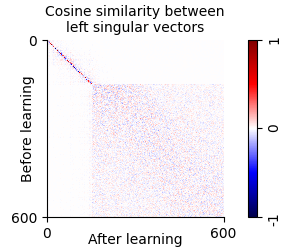

In [9]:
fig, ax = plt.subplots(1, figsize=(3, 2.5))
i = 600
im = ax.imshow(svd_pre[0][:,:i].T @ svd_post[0][:,:i], vmin=-1, vmax=1, 
               interpolation='none', cmap='seismic', aspect=1)
ax.set(xticks=[0,i], yticks=[0,i],
       title='Cosine similarity between\nleft singular vectors')
ax.set_xlabel('\nAfter learning', va='bottom')
ax.set_ylabel('\nBefore learning', va='top')
cax = fig.colorbar(im, ax=ax, fraction=0.04)
cax.set_ticks([-1,0,1], labels=[-1,0,1], rotation=90)
fig.savefig('../svg/supplementary/left_sv_similarity_full.svg')

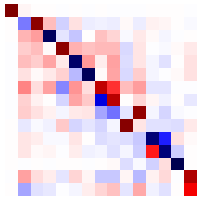

In [10]:
fig, ax = plt.subplots(1, figsize=(2,2))
i = 15
ax.imshow(svd_pre[0][:,:i].T @ svd_post[0][:,:i], vmin=-1, vmax=1, 
          interpolation='none', cmap='seismic', aspect=1)
ax.set_axis_off()
fig.savefig('../svg/supplementary/left_sv_similarity_zoomin.png')

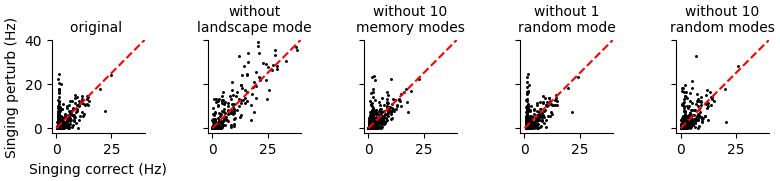

In [11]:
fig, ax = plt.subplots(1, N_case, sharex='all', sharey='all', figsize=(8, 1.8), 
                       constrained_layout=False)
l = 2
i_ctrl = np.argmin(np.abs(xs_offm)) # index of singing correct
i_pert = i_ctrl + 2 # index of singing perturb
for i, k in enumerate(case_names):
    z_ctrl = rate_offm[l*N_case+i][i_ctrl]
    z_pert = rate_offm[l*N_case+i][i_pert]
    ax[i].scatter(z_ctrl, z_pert, c='k', s=5)
    ax[i].plot([0,50], [0,50], c='r', ls='--')
    ax[i].set(aspect=1, title=k[::-1].replace('\n',' ',1)[::-1], xlim=[-2,40], ylim=[-2,40])
ax[0].set(ylabel='Singing perturb (Hz)')
ax[0].set(xlabel='Singing correct (Hz)')
fig.savefig('../svg/joint_dist_J_J_shuff_perturb.svg', bbox_inches='tight')

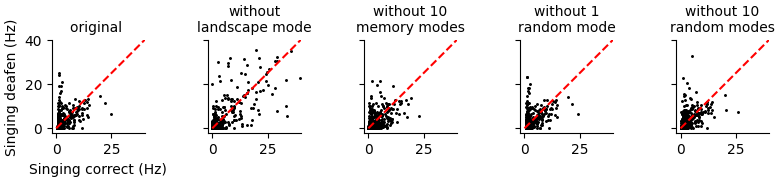

In [12]:
fig, ax = plt.subplots(1, N_case, sharex='all', sharey='all', figsize=(8, 1.8), 
                       constrained_layout=False)
l = 2
i_ctrl = np.argmin(np.abs(xs_onm - 1)) # index of singing correct
i_deaf = np.argmin(np.abs(xs_onm)) # index of singing deafening
for i, k in enumerate(case_names):
    z_ctrl = rate_onm[l*N_case+i][i_ctrl]
    z_deaf = rate_onm[l*N_case+i][i_deaf]
    ax[i].scatter(z_ctrl, z_deaf, c='k', s=5)
    ax[i].plot([0,50], [0,50], c='r', ls='--')
    ax[i].set(aspect=1, title=k[::-1].replace('\n',' ',1)[::-1], xlim=[-2,40], ylim=[-2,40])
ax[0].set(ylabel='Singing deafen (Hz)')
ax[0].set(xlabel='Singing correct (Hz)')
fig.savefig('../svg/supplementary/joint_dist_J_J_shuff_deafen.svg', bbox_inches='tight')

2 0.0908
3 0.0002
4 0.99
5 0.7802


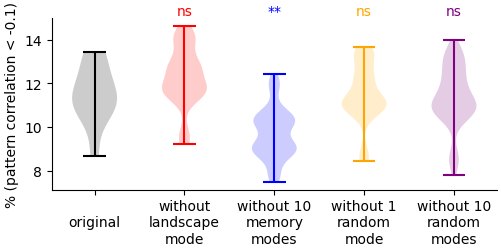

In [13]:
p_neg_corrs_ctrl = (corr_ctrl < -0.1).mean(axis=(1,2))*100
p_neg_corrs_disr = [(corr_disr[i::(N_case-1)] < -0.1).mean(axis=(1,2))*100 
                    for i in range(N_case-1)]

aux = [p_neg_corrs_ctrl] + p_neg_corrs_disr

fig, ax = plt.subplots(1, figsize=(5,2.5))
vp = ax.violinplot(aux)
colors = ['k', 'r', 'b', 'orange', 'purple']
for k in ('cbars','cmins','cmaxes'):
    vp[k].set_edgecolor(colors)
for pc, c in zip(vp['bodies'], colors):
    pc.set_facecolor(c)
    pc.set_alpha(0.2)

def statistic(x, y):
    return x.mean() - y.mean()
tests = [permutation_test([aux[0], aux[i]], statistic) for i in range(1, N_case)]

y_range = ax.get_ylim()
for i, (p, c) in enumerate(zip(tests, colors[1:]), 2):
    print(i, p.pvalue)
    if p.pvalue*2 < 0.05:
        ax.text(i, y_range[1], '*' if p.pvalue*2 > 0.01 else '**', 
                color=c, ha='center', va='bottom')
    else:
        ax.text(i, y_range[1], 'ns', color=c, ha='center', va='bottom')
ax.set(xticks=np.arange(len(case_names))+1, xticklabels=case_names, 
       ylabel='% (pattern correlation < -0.1)')
fig.savefig('../svg/supplementary/percent_J_corr_less_-0.1.svg')

In [14]:
def get_index(group):
    if group == 'landscape':
        i1 = res['order'].index('original')
        i2 = res['order'].index('landscape')
        i3 = res['order'].index('1 rand')
    elif group == 'memory':
        i1 = res['order'].index('original')
        i2 = res['order'].index('10 memory')
        i3 = res['order'].index('10 rand')
    return i1, i2, i3

def rel_mean(rate, group, ref_idx=None):
    ''' rate: list of (conditions, number of neurons)
        group: either 'landscape' or 'memory'; see above
    '''
    i1, i2, i3 = get_index(group)
    ctrl = (np.stack(rate[i1::N_case])).mean(axis=-1)
    disrupt_1 = (np.stack(rate[i2::N_case])).mean(axis=-1)
    disrupt_2 = (np.stack(rate[i3::N_case])).mean(axis=-1)
    if ref_idx is not None:
        ctrl = ctrl / ctrl[:,[ref_idx]]
        disrupt_1 /= disrupt_1[:,[ref_idx]]
        disrupt_2 /= disrupt_2[:,[ref_idx]]
    return (ctrl-1)*100, (disrupt_1-1)*100, (disrupt_2-1)*100
    
def grad2(x, y):
    i = np.where(x == 0)[0][0]
    return np.gradient(np.gradient(y, x, axis=-1), axis=-1)[:,i]

In [15]:
def plot_landscape_chars(group, pert_along):
    rate = rate_onm if pert_along == 'song' else rate_offm
    xs = xs_onm if pert_along == 'song' else xs_offm
    
    rms = rel_mean(rate, group, np.where(xs==0)[0][0])
    
    colors = ['k', 'r' if group == 'landscape' else 'b', 
              'orange' if group == 'landscape' else 'purple']
    
    fig1, ax1 = plt.subplots(1, figsize=(1.8,1.5))
    for i, c in enumerate(colors):
        plot_mean_std(ax1, rms[i].mean(axis=0), rms[i].std(axis=0), 
                      xs=xs, c=c, a_fill=0.2)

    fig2, ax2 = plt.subplots(1, figsize=(1.5,1.5))
    if pert_along == 'song':
        ax1.axvline(0, c='k', ls=':')
        ax1.text(0, 20, ' silence', ha='left')
        ax1.set(xlabel='song variation', ylabel='% rate increase', 
                xticks=[0, 1], xticklabels=[0, 'TS'])
        ax2.set(yticks=[0, 1], yticklabels=[0, 'TS'], ylabel='min. location', xticks=[])
        
        find_min = lambda a: xs[np.argmin(np.abs(np.gradient(a,xs,axis=1)),axis=1)]
        # find_min = lambda a: xs[np.argmin(a,axis=1)]
        aux = list(map(find_min, rms))
        
        xlabel, yticks = 'min. location', [0, 1.5]
    
    else:
        ax1.set(xlabel='non-song variation', ylabel='% rate increase')
        ax2.set(ylabel='concavity', xticks=[])
        
        aux = list(map(lambda y: grad2(xs, y), rms))
    
        xlabel, yticks = 'concavity', [0, 0.1]

    vp = ax2.violinplot(aux)
    for k in ('cbars','cmins','cmaxes'):
        vp[k].set_edgecolor(colors)
    for pc, c in zip(vp['bodies'], colors):
        pc.set_facecolor(c)
        pc.set_alpha(0.2)
    
    def statistic(x, y):
        return x.mean() - y.mean()
    tests = [permutation_test([aux[0], aux[1]], statistic, alternative='greater'),
             permutation_test([aux[0], aux[2]], statistic, alternative='greater')]
    
    y_range = ax2.get_ylim()
    for i, p in enumerate(tests, 1):
        if i == 1:
            y_sig = y_range[1]
            ax2.plot([i+0.1, i+0.9], [y_sig, y_sig], c='k')
            x_text = i + 0.5
        else: # 0 and 2; go higher
            y_sig = y_range[1] * 1.15 - y_range[0] * 0.15
            ax2.plot([1.1, 2.9], [y_sig, y_sig], c='k')
            x_text = 2

        print(i, p.pvalue)
        if p.pvalue < 0.05:
            ax2.text(x_text, y_sig, '*' if p.pvalue > 0.01 else '**', 
                     ha='center', va='bottom')
        else:
            ax2.text(x_text, y_sig, 'ns', ha='center', va='bottom')
    return fig1, ax1, fig2, ax2

1 0.0001
2 0.553


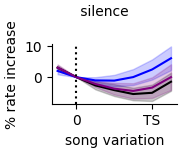

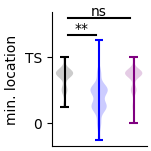

In [16]:
fig1, ax1, fig2, ax2 = plot_landscape_chars(group='memory', pert_along='song')
fig1.savefig('../svg/onm_group_song_pert.svg')
fig2.savefig('../svg/onm_group_min_loc.svg')

1 0.051
2 0.2551


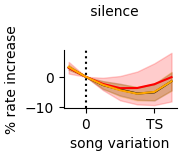

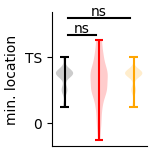

In [17]:
fig1, ax1, fig2, ax2 = plot_landscape_chars(group='landscape', pert_along='song')
fig1.savefig('../svg/offm_group_song_pert.svg')
fig2.savefig('../svg/offm_group_min_loc.svg')

1 0.0001
2 0.0001


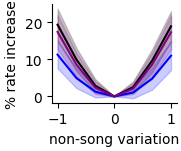

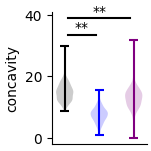

In [18]:
fig1, ax1, fig2, ax2 = plot_landscape_chars(group='memory', pert_along='other')
fig1.savefig('../svg/onm_group_nonsong_pert.svg')
fig2.savefig('../svg/onm_group_concav.svg')

1 0.0001
2 0.4073


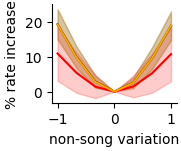

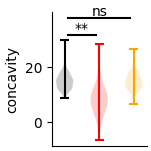

In [19]:
fig1, ax1, fig2, ax2 = plot_landscape_chars(group='landscape', pert_along='other')
fig1.savefig('../svg/offm_group_nonsong_pert.svg')
fig2.savefig('../svg/offm_group_concav.svg')

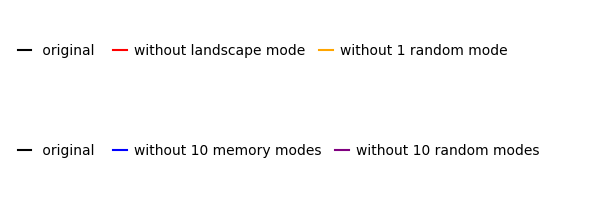

In [20]:
fig, ax = plt.subplots(2, figsize=(6,2))
for i, c in zip((0,1,3), ('k','r','orange')):
    ax[0].plot(0, 0, c=c, label=case_names[i].replace('\n', ' '))
for j, c in zip((0,2,4), ('k','b','purple')):
    ax[1].plot(0, 0, c=c, label=case_names[j].replace('\n', ' '))
for i in range(2):
    ax[i].set_axis_off()
    ax[i].legend(loc='center left', ncols=3)
fig.savefig('../svg/dummy_label_EIrec_analysis.svg')